### Notebook para fazer inferência com os modelos

In [14]:
import os

root_dir = "/home/lorenzo-varaschin/solar_forecasting/mestrado/projeto_visao_comp/model_checkpoints"#"/home/jovyan/arquivos/solar_forecasting/projeto_visao_comp/model_checkpoints"
model_checkpoints = {ckpt_name.replace(".ckpt", ""): os.path.join(root_dir, ckpt_name) for ckpt_name in sorted(os.listdir(root_dir)) if ckpt_name.startswith("_")}
model_checkpoints

In [2]:
from predformer import PredFormer
from data import make_dataloaders

device = 0 # cpu ou número da GPU

# carregar os modelos e seus checkpoints
models = dict()
for model_name, model_ckpt in model_checkpoints.items():
    models[model_name] = PredFormer.load_from_checkpoint(
        model_ckpt,
        map_location=f"cuda:{device}" if isinstance(device, int) else device
    ).eval()
train_dataloader, val_dataloader, test_dataloader = make_dataloaders(batch_size=16)

/home/lorenzo-varaschin/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.5.0.post0


In [3]:
from torch.utils.data import default_collate

def get_batch(dataset, idxs_):
    """
    Função para criar um batch do dataset a partir dos idxs_ para poder utilizar o model.sample
    """
    samples = [dataset[i] for i in idxs_]
    batch = default_collate(samples)
    return batch

In [4]:
import matplotlib.pyplot as plt
import numpy as np
def plot_predictions(sample_idx, models_, dataset_):
    batch = get_batch(dataset_, sample_idx)
    figs_, axes_ = list(), list()
    for i in range(len(sample_idx)):
        fig, ax = plt.subplots(len(models_)+1, 5, figsize=(15, 4*len(models_)), layout="constrained")
        figs_.append(fig), axes_.append(ax)
    for j, model_ in enumerate(models_):
        outs_ = model_.sample(batch, 0)
        for i, (seq_trues, seq_preds, seq_ghi_trues, seq_ghi_preds) in enumerate(zip(outs_["trues"], outs_["preds"], outs_["tgt_ghi"], outs_["ghi_preds"])):
            if j == 0:
                for t, (img_trues, ghi_trues) in enumerate(zip(seq_trues, seq_ghi_trues)):
                    axes_[i][j, t].imshow(np.clip(img_trues.permute(1, 2, 0), 0, 1))
                    axes_[i][j, t].set_title(f"Ground Truth (t+{2*(t+1)})\n{ghi_trues:.2f} W/m2")
                    axes_[i][j, t].set_axis_off()
            for t, (img_preds, ghi_preds) in enumerate(zip(seq_preds, seq_ghi_preds)):
                error_ = ghi_preds - seq_ghi_trues[t] 
                axes_[i][j+1, t].imshow(np.clip(img_preds.permute(1, 2, 0), 0, 1))
                axes_[i][j+1, t].set_title(f"Model {j+1} (t+{2*(t+1)}) \n{ghi_preds:.2f} ({'+' if error_ > 0 else ''}{error_:.2f})W/m2")
                axes_[i][j+1, t].set_axis_off()

In [5]:
list(models.keys())

['_1__encoder_only__linear__space_time',
 '_2__encoder_only__linear__quad_TSST',
 '_3__encoder_only__unet__space_time',
 '_4__encoder_only__unet__quad_TSST',
 '_5__decoder_only__linear__space_time',
 '_6__decoder_only__linear__quad_TSST',
 '_7__decoder_only__unet__space_time',
 '_8__decoder_only__unet__quad_TSST']

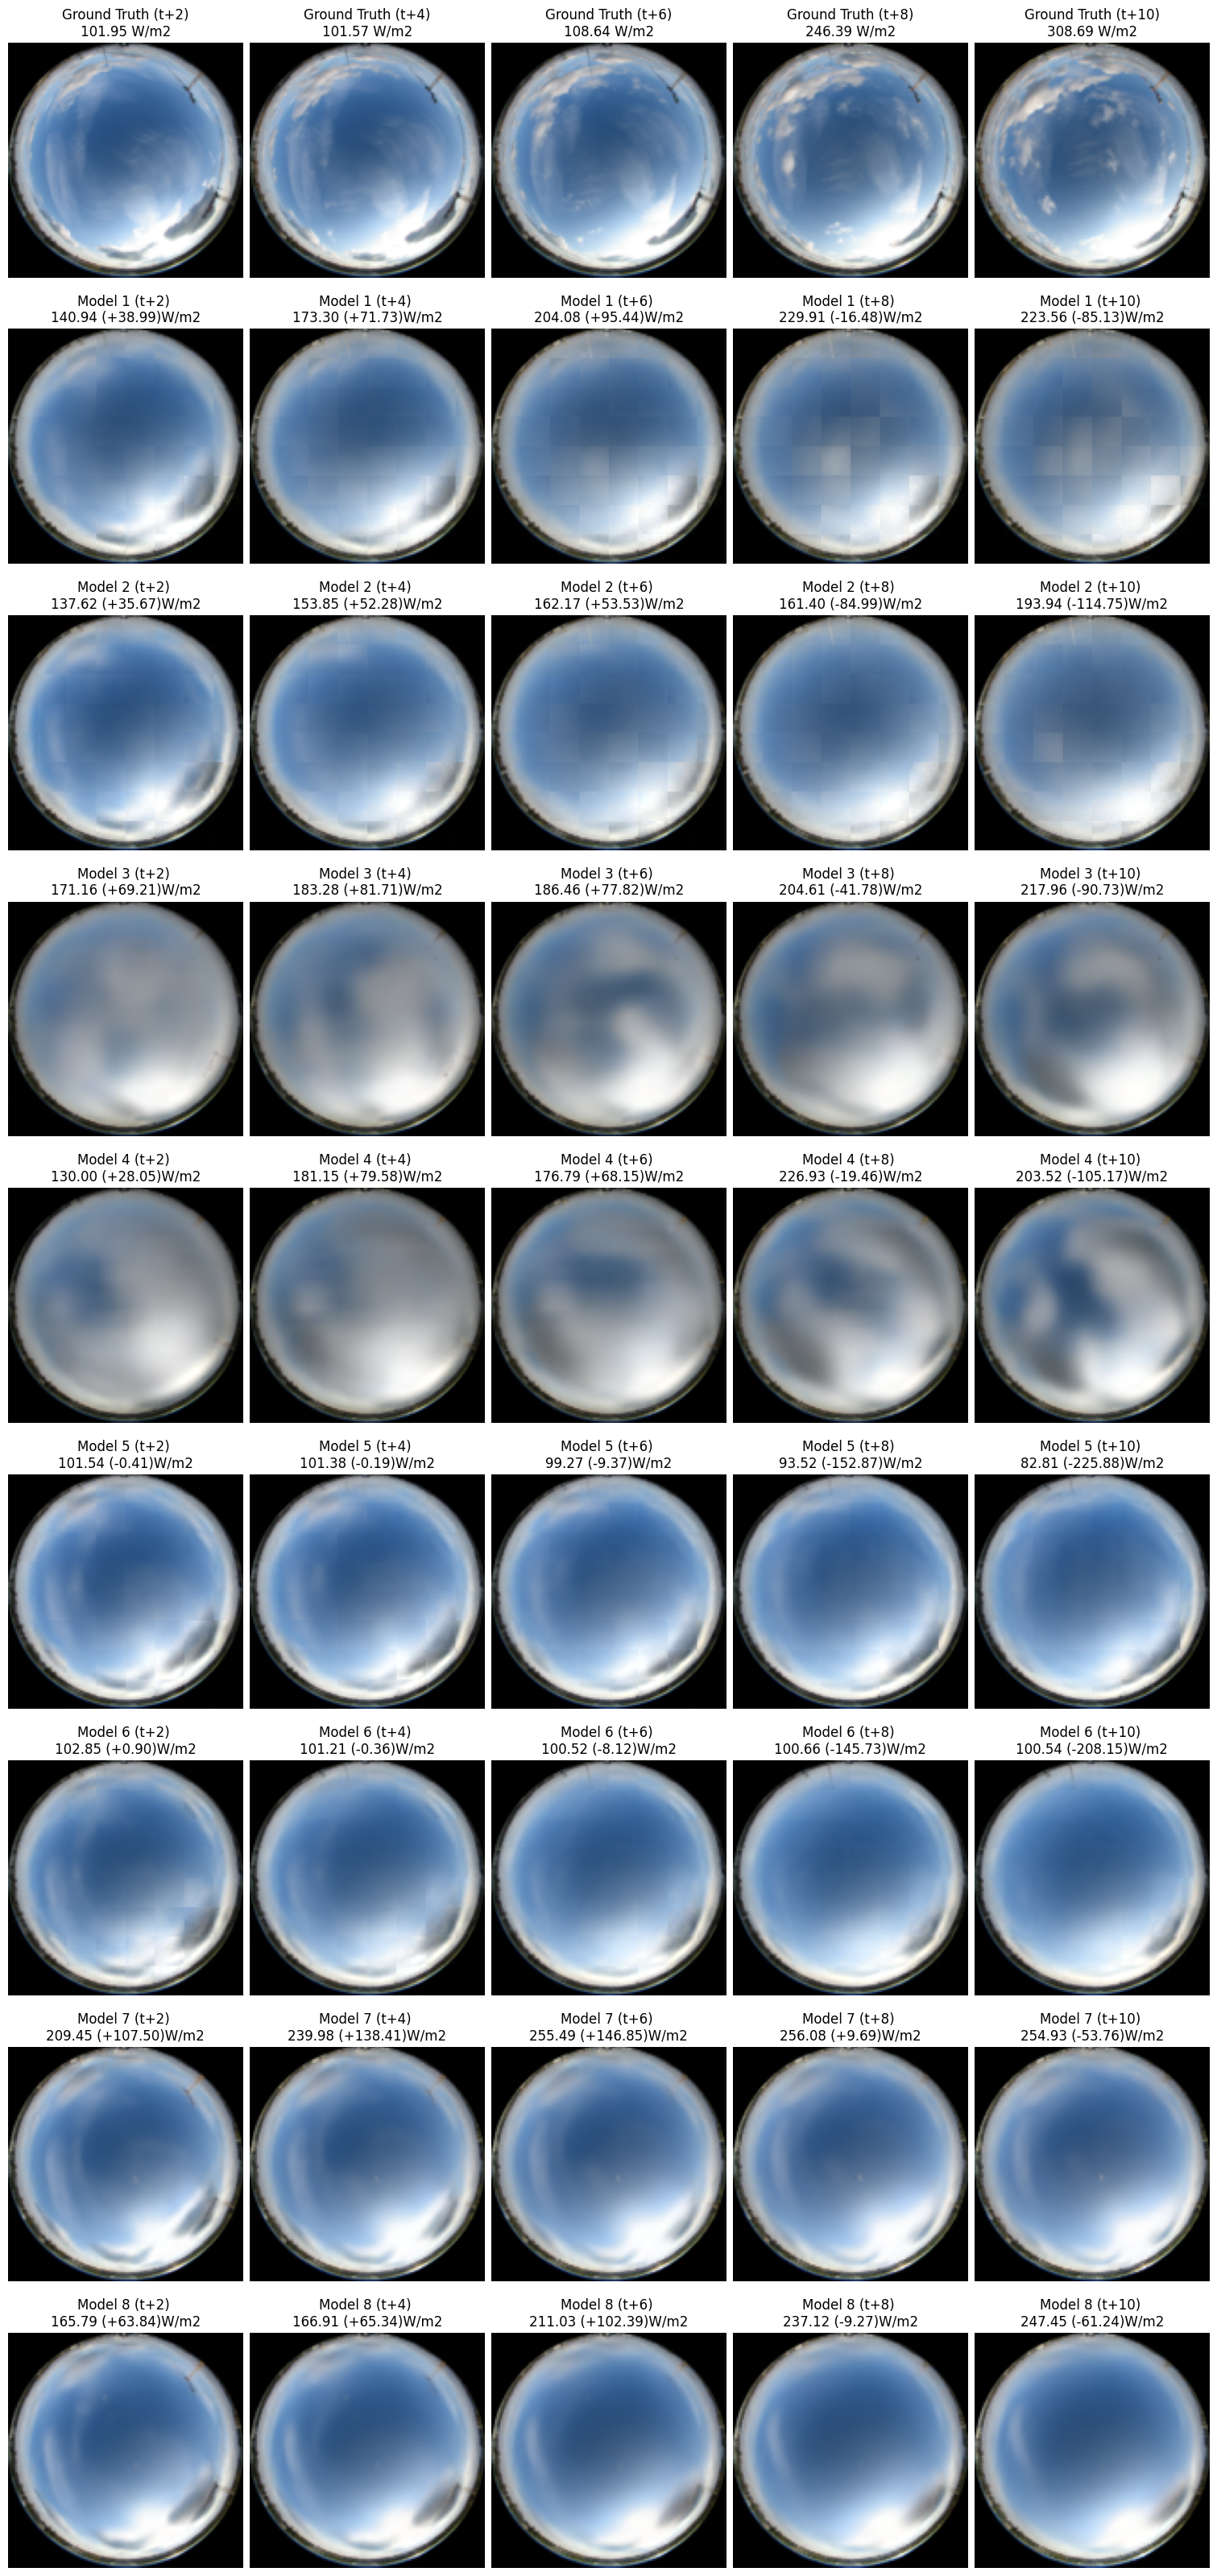

In [13]:
idx_ = [47080]
plot_predictions(
    sample_idx=idx_,
    models_=np.array(list(models.values())),
    dataset_=test_dataloader.dataset
)